In [ ]:
import pandas as pd
df = pd.read_excel('/content/DatosModeloElizabeta.xlsx')

In [ ]:
print(df.dtypes)

Nombre del archivo                 object
ID                                 object
NER_personas                       object
NER-Organizaciones                 object
NER Fechas                         object
Hechos                             object
Pretensiones                       object
Consideraciones 1                  object
Consideraciones 2                  object
Consideraciones 3                  object
Consideraciones 4                  object
Sección resuelve                   object
Trigramas_texto                    object
Trigramas_relevantes               object
Etiqueta                            int64
Hechos_tokens                      object
Pretensiones_tokens                object
Hechos_word_count                   int64
Pretensiones_word_count             int64
Hechos_top_words                   object
Pretensiones_top_words             object
Hechos_top_entities                object
Pretensiones_top_entities          object
Hechos_pos_tags                   

In [ ]:
!pip install transformers==4.28.1

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch

In [ ]:
# Cargar el modelo y el tokenizer preentrenados
tokenizer = AutoTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased")
model = AutoModel.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased")

# Función para obtener embeddings
def obtener_embeddings(texto):
  tokens = tokenizer(texto, return_tensors="pt", truncation=True, padding=True)
  with torch.no_grad():
    outputs = model(**tokens)
  embeddings = outputs.last_hidden_state.mean(dim=1).numpy()
  return embeddings

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias

In [ ]:
# Aplicar la función a la columna "Hechos"
df['embeddings'] = df['Hechos'].apply(obtener_embeddings)

In [ ]:
print(df['embeddings'].dtype)

object


In [ ]:
import numpy as np
texto_ejemplo = df['Hechos'].iloc[0]
embeddings_ejemplo = obtener_embeddings(texto_ejemplo)
print(type(embeddings_ejemplo))

<class 'numpy.ndarray'>


In [ ]:
print(df)

                                    Nombre del archivo        ID  \
0               -1_2020-800-00217_2022-01-252219-1.pdf    1 sent   
1    115557 SEI KOU S.A. VS. ÁLVARO ESLAVA JÁCOME y...    2 sent   
2    1283_JOSE_LUIS_MALVEHY_y_OTROS_VS._SERVISATELI...    3 sent   
3    134677 GUSTAVO FERNANDO MUÑOZ PEDRAZA Y OTRO V...    4 sent   
4    1933_CARLOS_HAKIM_vs_JORGE_HAKIM_Y_OTROS_10_10...    5 sent   
..                                                 ...       ...   
159   Sentencia n.° 801-76  30 de octubre del 2014.pdf  161 sent   
160  Sentencia n.° 801-76  30 de octubre del 2014.p...  162 sent   
161  Sentencia n.° 801-82 de 20 de noviembre del 20...  163 sent   
162  Sentencia n.º 800-83 de 03 de diciembre del 20...  164 sent   
163  Sentencia nº. 800-116 de 4 de septiembre del 2...  165 sent   

                                          NER_personas  \
0    ['joaquín fernando vélez', 'joaquín fernando v...   
1    ['carlos darío camargo la hoz', 'luis fernando...   
2    ['se

In [ ]:
import numpy as np

# Encuentra la longitud del vector más largo
longitud_maxima = max(df['embeddings'].apply(len))

# Aplica padding a los vectores
df['embeddings_padded'] = df['embeddings'].apply(lambda x: np.pad(x, (0, longitud_maxima - len(x)), 'constant'))

In [ ]:
print(df)

                                    Nombre del archivo        ID  \
0               -1_2020-800-00217_2022-01-252219-1.pdf    1 sent   
1    115557 SEI KOU S.A. VS. ÁLVARO ESLAVA JÁCOME y...    2 sent   
2    1283_JOSE_LUIS_MALVEHY_y_OTROS_VS._SERVISATELI...    3 sent   
3    134677 GUSTAVO FERNANDO MUÑOZ PEDRAZA Y OTRO V...    4 sent   
4    1933_CARLOS_HAKIM_vs_JORGE_HAKIM_Y_OTROS_10_10...    5 sent   
..                                                 ...       ...   
159   Sentencia n.° 801-76  30 de octubre del 2014.pdf  161 sent   
160  Sentencia n.° 801-76  30 de octubre del 2014.p...  162 sent   
161  Sentencia n.° 801-82 de 20 de noviembre del 20...  163 sent   
162  Sentencia n.º 800-83 de 03 de diciembre del 20...  164 sent   
163  Sentencia nº. 800-116 de 4 de septiembre del 2...  165 sent   

                                          NER_personas  \
0    ['joaquín fernando vélez', 'joaquín fernando v...   
1    ['carlos darío camargo la hoz', 'luis fernando...   
2    ['se

Red neuronal

In [ ]:
!pip install tensorflow==2.12.0

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

In [ ]:
print(type(df['embeddings_padded'].iloc[0]))
print(df['embeddings_padded'].iloc[0].shape)

<class 'numpy.ndarray'>
(1, 768)


In [ ]:
# Prepara los datos
X = np.stack(df['embeddings_padded'])
y = df['Etiqueta']

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

# Crea un objeto StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)  # Ajusta test_size según sea necesario

In [ ]:
# Divide los datos en entrenamiento y prueba
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

# Divide los datos de entrenamiento en entrenamiento y validación
sss_val = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
for train_index, val_index in sss_val.split(X_train, y_train):
    X_train_final, X_val = X_train[train_index], X_train[val_index]
    y_train_final, y_val = y_train.iloc[train_index], y_train.iloc[val_index]  # Usamos .iloc aquí

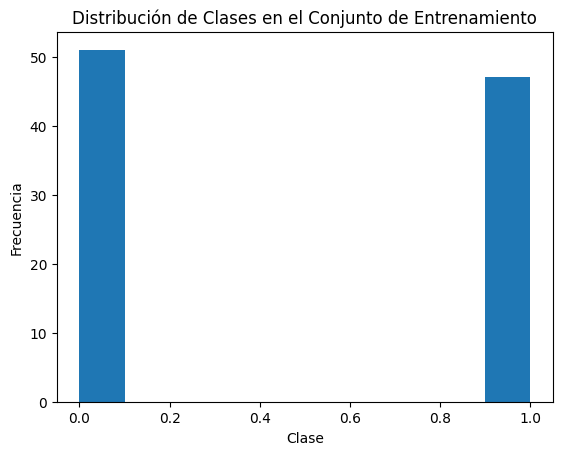

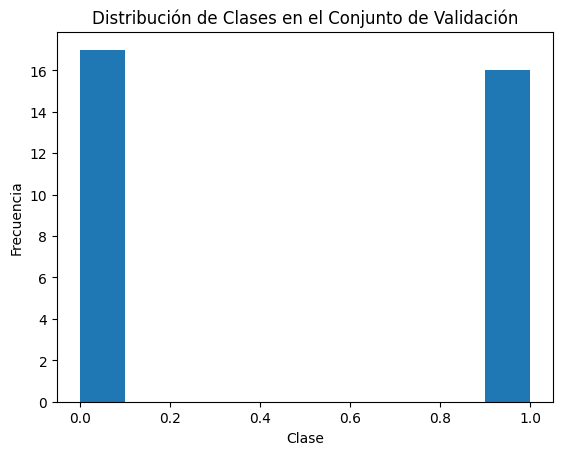

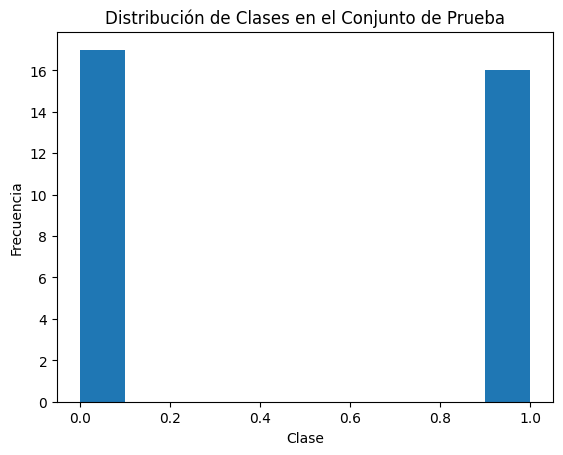

In [ ]:
import matplotlib.pyplot as plt

# Verificar balance en el conjunto de entrenamiento
plt.hist(y_train_final)
plt.title('Distribución de Clases en el Conjunto de Entrenamiento')
plt.xlabel('Clase')
plt.ylabel('Frecuencia')
plt.show()

# Verificar balance en el conjunto de validación
plt.hist(y_val)
plt.title('Distribución de Clases en el Conjunto de Validación')
plt.xlabel('Clase')
plt.ylabel('Frecuencia')
plt.show()

# Verificar balance en el conjunto de prueba
plt.hist(y_test)
plt.title('Distribución de Clases en el Conjunto de Prueba')
plt.xlabel('Clase')
plt.ylabel('Frecuencia')
plt.show()

Modelo RNN

In [ ]:
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout, Flatten # Import Flatten
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Ensure y_train and y_val are one-hot encoded
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [ ]:
# Define el modelo
num_classes = y_train.shape[1]
modelo = Sequential()
modelo.add(Bidirectional(LSTM(250, return_sequences=True), input_shape=(X.shape[1], X.shape[2])))
modelo.add(Dropout(0.2))  # Agrega dropout para prevenir overfitting
modelo.add(Bidirectional(LSTM(70)))
modelo.add(Dropout(0.2))
# Move Flatten layer before the Dense layer
modelo.add(Flatten()) # New line moved here
modelo.add(Dense(num_classes, activation='softmax'))

In [ ]:
# Compila el modelo
modelo.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Define el early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entrena el modelo con early stopping
historial = modelo.fit(X_train, y_train, epochs=100, batch_size=32,
                    validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/100
5/5 [==============================] - 11s 745ms/step - loss: 0.6978 - accuracy: 0.5420 - val_loss: 0.6727 - val_accuracy: 0.5152
Epoch 2/100
5/5 [==============================] - 0s 49ms/step - loss: 0.6749 - accuracy: 0.5954 - val_loss: 0.6297 - val_accuracy: 0.9697
Epoch 3/100
5/5 [==============================] - 0s 44ms/step - loss: 0.6435 - accuracy: 0.7099 - val_loss: 0.5814 - val_accuracy: 0.9394
Epoch 4/100
5/5 [==============================] - 0s 48ms/step - loss: 0.6310 - accuracy: 0.6412 - val_loss: 0.5393 - val_accuracy: 0.7879
Epoch 5/100
5/5 [==============================] - 0s 44ms/step - loss: 0.5728 - accuracy: 0.7328 - val_loss: 0.4880 - val_accuracy: 0.8182
Epoch 6/100
5/5 [==============================] - 0s 46ms/step - loss: 0.5508 - accuracy: 0.7252 - val_loss: 0.4041 - val_accuracy: 0.9394
Epoch 7/100
5/5 [==============================] - 0s 49ms/step - loss: 0.5091 - accuracy: 0.7252 - val_loss: 0.3325 - val_accuracy: 0.9394
Epoch 8/100
5/5 [=

Métricas

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Predicciones en los datos de entrenamiento y validación
y_pred_train = modelo.predict(X_train)
y_pred_val = modelo.predict(X_val)

2/2 [==============================] - 0s 7ms/step


In [ ]:
# Convierte las predicciones a etiquetas
y_pred_train_labels = np.argmax(y_pred_train, axis=1)
y_pred_val_labels = np.argmax(y_pred_val, axis=1)
y_true_train_labels = np.argmax(y_train, axis=1)
y_true_val_labels = np.argmax(y_val, axis=1)

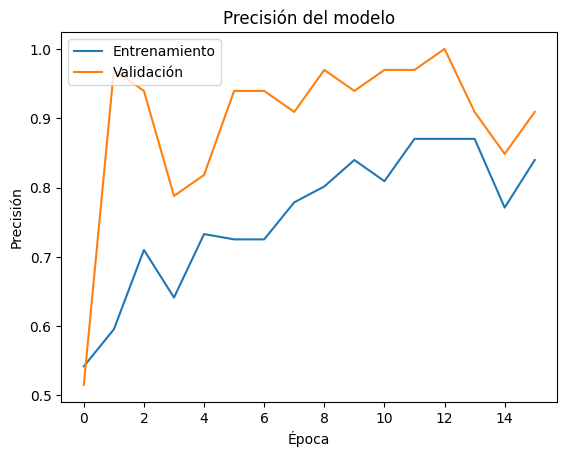

In [ ]:
import matplotlib.pyplot as plt

# Gráfico de precisión
plt.plot(historial.history['accuracy'])
plt.plot(historial.history['val_accuracy'])
plt.title('Precisión del modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')
plt.show()

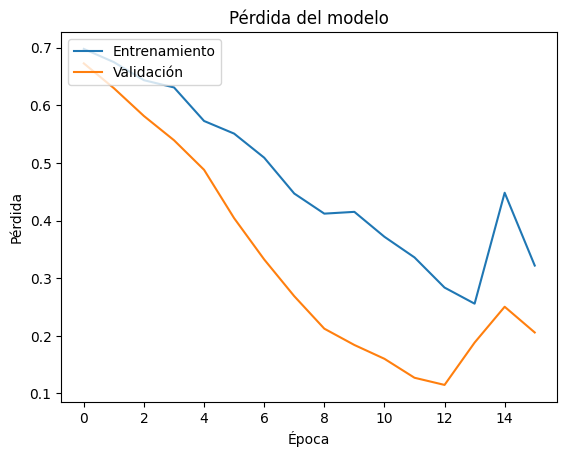

In [ ]:
# Gráfico de pérdida
plt.plot(historial.history['loss'])
plt.plot(historial.history['val_loss'])
plt.title('Pérdida del modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')
plt.show()

In [ ]:
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support

# Calcula las métricas para entrenamiento y validación
train_metrics = precision_recall_fscore_support(y_true_train_labels, y_pred_train_labels, average='weighted')
val_metrics = precision_recall_fscore_support(y_true_val_labels, y_pred_val_labels, average='weighted')

# Crea un DataFrame para mostrar las métricas
df_metrics = pd.DataFrame({
    'Métrica': ['Precisión', 'Recall', 'F1-score'],
    'Entrenamiento': [train_metrics[0], train_metrics[1], train_metrics[2]],
    'Validación': [val_metrics[0], val_metrics[1], val_metrics[2]]
})

print(df_metrics)

     Métrica  Entrenamiento  Validación
0  Precisión       0.908884         1.0
1     Recall       0.908397         1.0
2   F1-score       0.908429         1.0


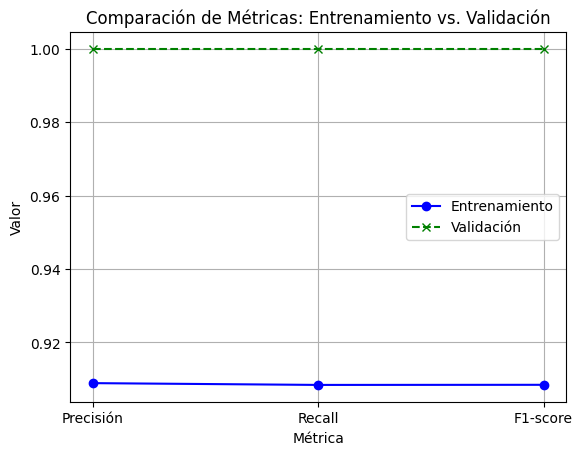

In [ ]:
import matplotlib.pyplot as plt

# Datos para las métricas
metricas = ['Precisión', 'Recall', 'F1-score']
valores_entrenamiento = df_metrics['Entrenamiento']
valores_validacion = df_metrics['Validación']

# Gráfico de líneas
plt.plot(metricas, valores_entrenamiento, marker='o', linestyle='-', color='blue', label='Entrenamiento')
plt.plot(metricas, valores_validacion, marker='x', linestyle='--', color='green', label='Validación')

plt.xlabel('Métrica')
plt.ylabel('Valor')
plt.title('Comparación de Métricas: Entrenamiento vs. Validación')
plt.legend()
plt.grid(True)  # Agrega una cuadrícula para mejorar la legibilidad
plt.show()

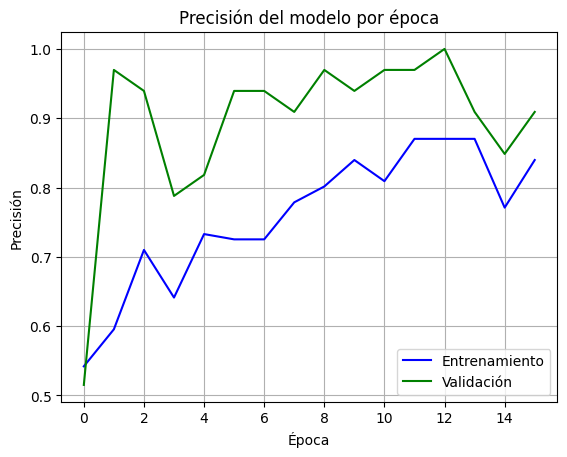

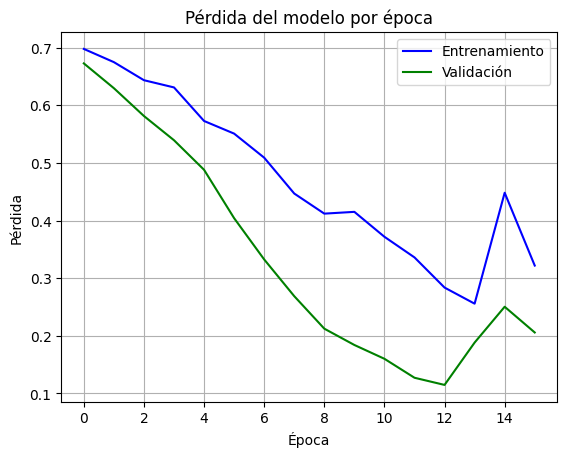

In [ ]:
import matplotlib.pyplot as plt

# Gráfico de precisión
plt.plot(historial.history['accuracy'], color='blue', label='Entrenamiento')
plt.plot(historial.history['val_accuracy'], color='green', label='Validación')
plt.title('Precisión del modelo por época')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend()
plt.grid(True)
plt.show()

# Gráfico de pérdida
plt.plot(historial.history['loss'], color='blue', label='Entrenamiento')
plt.plot(historial.history['val_loss'], color='green', label='Validación')
plt.title('Pérdida del modelo por época')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend()
plt.grid(True)
plt.show()

**Pruebas con texto**

In [ ]:
def clasificar_texto(texto, modelo, tokenizer):
  # 1. Obtener embeddings del texto
  embeddings = obtener_embeddings(texto)

  # 2. Ajustar dimensiones para que coincidan con la entrada del modelo
  embeddings_reshaped = np.expand_dims(embeddings, axis=0)

  # 3. Realizar la predicción
  prediccion = modelo.predict(embeddings_reshaped)

  # 4. Obtener la clase predicha
  clase_predicha = np.argmax(prediccion, axis=1)[0]

  return clase_predicha

In [ ]:
# Ejemplo de uso
texto_prueba = "El señor Carlos Hernán Malvehy, en calidad de apoderado especial de S3 Wireless, Phillip Stephenson, María Stephenson y John Stephenson, se entrevistó con Gina Achury de Servisatélite S.A. para entregarle acciones endosadas a favor de Servisatélite S.A. por el pago de $150,000 dólares, pero Servisatélite se negó a recibirlas.  Debido a la negativa de Servisatélite de recibir las acciones, Carlos Hernán Malvehy hizo la entrega de las acciones con su carta de traspaso. Existe una discusión sobre si la acción resolutoria es procedente cuando ambos contratantes han incumplido sus respectivas obligaciones.Se analiza el concepto de sustancia o calidad esencial de un objeto como causal de error que vicia el consentimiento"
clase = clasificar_texto(texto_prueba, modelo, tokenizer)

1/1 [==============================] - 0s 39ms/step


In [ ]:
print(f"Clase predicha: {clase}")

Clase predicha: 0


Clase 2

In [ ]:
# Ejemplo de uso
texto_prueba = "El administrador contrató a su esposa con dinero de la sociedad sin notificar a los socios de forma adecuada, no demostró la idoneidad"
clase = clasificar_texto(texto_prueba, modelo, tokenizer)

1/1 [==============================] - 0s 39ms/step


In [ ]:
print(f"Clase predicha: {clase}")

Clase predicha: 1


Prueba 2

In [ ]:
# Ejemplo de uso
texto_prueba = "La demanda alega que varios contratos celebrados por la sociedad demandada fueron suscritos en violación del régimen de conflicto de intereses, pues los contratistas eran familiares del representante legal de la sociedad"
clase = clasificar_texto(texto_prueba, modelo, tokenizer)

1/1 [==============================] - 0s 42ms/step


In [ ]:
print(f"Clase predicha: {clase}")

Clase predicha: 1


Prueba 3

In [ ]:
# Ejemplo de uso
texto_prueba = "los demandantes buscan que se declare la nulidad de diversos actos y contratos celebrados por los demandados, se reconozca una indemnización de perjuicios y se restablezca el patrimonio de la compañía Hacienda Los Mangos López de C. & Cia. S. en C."
clase = clasificar_texto(texto_prueba, modelo, tokenizer)

1/1 [==============================] - 0s 36ms/step


In [ ]:
print(f"Clase predicha: {clase}")

Clase predicha: 1


Prueba 4

In [ ]:
# Ejemplo de uso
texto_prueba = "El administrador citó a todos los socios, pero no asistió a la reunión"
clase = clasificar_texto(texto_prueba, modelo, tokenizer)

1/1 [==============================] - 0s 46ms/step


In [ ]:
print(f"Clase predicha: {clase}")

Clase predicha: 0
